In [1]:
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import json
import os
import rasterio
import numpy as np


## cut raster

In [2]:
gdf = gpd.read_file('../../konverto_data_package/polygons/polygons.geojson')

In [3]:
gdf

type                                           geometry
0           winery                                 MULTIPOLYGON EMPTY
1           winery  MULTIPOLYGON (((675007.413 5143326.011, 675067...
2           winery  MULTIPOLYGON (((675066.550 5143267.678, 675149...
3           winery  MULTIPOLYGON (((674760.935 5143198.037, 674834...
4           winery  MULTIPOLYGON (((673672.158 5143505.380, 673678...
..             ...                                                ...
96   apple orchard  MULTIPOLYGON (((673977.481 5136172.898, 674005...
97          winery  MULTIPOLYGON (((673322.831 5136427.445, 673328...
98          winery  MULTIPOLYGON (((672685.775 5139609.934, 672709...
99   apple orchard  MULTIPOLYGON (((678006.627 5145427.665, 677996...
100  apple orchard  MULTIPOLYGON (((678007.678 5145426.475, 678070...

[101 rows x 2 columns]

In [4]:
gdf1 = gdf.loc[11]
gdf1

type                                                   winery
geometry    MULTIPOLYGON (((673161.0209203674 5138097.8153...
Name: 11, dtype: object

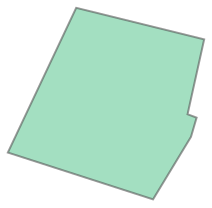

In [5]:
gdf.loc[8].geometry
    

In [6]:
dataset = rasterio.open('../../konverto_data_package/climate/tmean/tmean_2020_01_21.tif')
dataset

<open DatasetReader name='../../konverto_data_package/climate/tmean/tmean_2020_01_21.tif' mode='r'>

In [7]:
out, inside  = mask(dataset, gdf1[['geometry']], crop=True, invert=False, all_touched=True, nodata=np.nan)
out

array([[[       nan, 0.9553406 ],
        [0.88942724, 0.7424053 ],
        [0.8325057 , 0.34043524]]], dtype=float32)

In [8]:
def get_datasets():

    directory = "../../konverto_data_package"
    
    datasets = {}
    for root, dirs, files in os.walk(directory):
        # print(f"Current directory: {root}")
        if "visual" in root:
            continue

        tif_files = [f for f in files if f.endswith(".tif") and not f.startswith(".")]
        tif_paths = [os.path.join(root, f) for f in tif_files]


        if len(tif_files) > 0:

            if "climate" in tif_paths[0]:
                dates = ["-".join(f.replace(".tif", "").split("_")[1:]) for f in tif_files]
            elif "satellite" in tif_paths[0]:
                datestrings = [f.replace(".tif", "").split("_")[0] for f in tif_files]
                dates = [d[:4] + "-" + d[4:6] + "-" + d[6:] for d in datestrings]
            else:
                dates = None
            

            if dates:
                dataset_name = os.path.basename(root)
                
                for date, fp in zip(dates, tif_paths):
                    if date in datasets:
                        datasets[date].update({dataset_name: fp})
                    else:
                        datasets[date] = {dataset_name: fp}
            
            if "terrain" in tif_paths[0]:
                dataset_names = [n.replace(".tif", "") for n in tif_files]
                for date in datasets.keys():
                    for dn, fp in zip(dataset_names, tif_paths):
                        datasets[date].update({dn: fp})

                    


    return datasets

In [9]:
datasets = get_datasets()

In [10]:
datasets["2020-03-22"]

{'reci': '../../konverto_data_package/satellite/indices/reci/20200322_reci.tif',
 'ndwi': '../../konverto_data_package/satellite/indices/ndwi/20200322_ndwi.tif',
 'ndvi': '../../konverto_data_package/satellite/indices/ndvi/20200322_ndvi.tif',
 'gdd': '../../konverto_data_package/climate/gdd/gdd_2020_03_22.tif',
 'tmax': '../../konverto_data_package/climate/tmax/tmax_2020_03_22.tif',
 'tmin': '../../konverto_data_package/climate/tmin/tmin_2020_03_22.tif',
 'tmean': '../../konverto_data_package/climate/tmean/tmean_2020_03_22.tif',
 'pmm': '../../konverto_data_package/climate/pmm/pmm_2020_03_22.tif'}

In [34]:
def extract_raster_data_from_polygon(polygon, date_string = "2020-03-22"):

    dataset_paths = get_datasets()
    mean = {}
    std = {}
    for dataset_name, fpath in dataset_paths[date_string].items():
        if dataset_name in ['reci', 'gdd', 'tmax', 'tmin', 'tmean', 'pmm']:
            continue
        dataset = rasterio.open(fpath)
        mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
        std[dataset_name] = np.nanstd(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])

    return mean, std

In [12]:
data_2020_03_22 = extract_raster_data_from_polygon(gdf.loc[8][['geometry']], "2020-03-22")

In [13]:
mean__2020_03_22, std_2020_03_22 = data_2020_03_22

In [14]:
mean__2020_03_22

{'ndwi': -0.0628448, 'ndvi': 0.200307}

In [15]:
std_2020_03_22

{'ndwi': 0.014411566, 'ndvi': 0.019187992}

In [16]:
gdf.loc[8]['type']

'winery'

In [38]:
dti = pd.date_range("2020-01-01", end="2022-12-31", freq="D")
d = dti[81]
gdf.loc[8][['geometry']],d.strftime("%Y-%m-%d")
extract_raster_data_from_polygon(gdf.loc[8][['geometry']],d.strftime("%Y-%m-%d"))[0]

{'ndwi': -0.0628448, 'ndvi': 0.200307}

In [ ]:
dti = pd.date_range("2020-01-01", end="2022-12-31", freq="D")
rows = []
for i in range(len(gdf)):
# for i in range(1,3):
    print(i)
    for d in dti:
        # x,y = extract_raster_data_from_polygon(gdf.loc[i][['geometry']],d.strftime("%Y-%m-%d"))[0]
        # row = (gdf.loc[i]['type'], x, y)
        try:
            raster_dict = extract_raster_data_from_polygon(gdf.loc[i][['geometry']],d.strftime("%Y-%m-%d"))[0]
            row = (d, i, gdf.loc[i]['type'], raster_dict['ndvi'], raster_dict['ndwi'])
        except:
            #print(d)
            row = (d, i, gdf.loc[i]['type'], np.nan, np.nan)
        rows.append(row)
ts = pd.DataFrame(data=rows)



In [58]:
ts.columns = ['date', 'polygon', 'type', 'ndvi', 'ndwi']
ts.to_csv('ndvi_ndwi.csv')
ts_df = ts
ts_df.loc[(ts_df['ndvi'] > 1) | (ts_df['ndvi'] < -1), 'ndvi'] = np.nan
ts_df.loc[(ts_df['ndwi'] > 1) | (ts_df['ndwi'] < -1), 'ndwi'] = np.nan
ts_df

date  polygon           type      ndvi      ndwi
0      2020-01-01        0         winery       NaN       NaN
1      2020-01-02        0         winery       NaN       NaN
2      2020-01-03        0         winery       NaN       NaN
3      2020-01-04        0         winery       NaN       NaN
4      2020-01-05        0         winery       NaN       NaN
...           ...      ...            ...       ...       ...
110691 2022-12-27      100  apple orchard  0.097869  0.049794
110692 2022-12-28      100  apple orchard       NaN       NaN
110693 2022-12-29      100  apple orchard       NaN       NaN
110694 2022-12-30      100  apple orchard       NaN       NaN
110695 2022-12-31      100  apple orchard       NaN       NaN

[110696 rows x 5 columns]

In [60]:
import plotly.express as px

fig = px.scatter(ts_df, x="date", y="ndwi", color="type", title="Simple Time Series Plot")
fig.show()

In [33]:
ts.to_csv('../all_polygons_3Year_time_series_ndvi_ndwi.csv')

In [51]:
df = pd.read_csv('../fiel8_4Year_time_series_ndvi_ndwi.csv')
df.rename(columns={df.columns[0]: 'date'}, inplace=True)
df.loc[(df['ndvi'] > 1) | (df['ndvi'] < -1), 'ndvi'] = np.nan
df.describe()

ndwi        ndvi
count  465.000000  464.000000
mean    -0.154806    0.289310
std      0.152792    0.189493
min     -0.396367   -0.301025
25%     -0.261300    0.226782
50%     -0.184923    0.295931
75%     -0.107261    0.429029
max      0.415207    0.609937

In [54]:
import plotly.express as px

fig = px.scatter(df, x="date", y="ndvi", title="Simple Time Series Plot")
fig.show()